In [294]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import os
import probfit
from scipy.optimize import curve_fit, minimize
from scipy.stats import chisquare
from scipy.interpolate import interp2d, RectBivariateSpline, RegularGridInterpolator
from scipy.integrate import trapz, cumtrapz
from time import time
from random import random
from numpy import sin, cos
from math import pi
from iminuit import Minuit
from pprint import pprint

In [ ]:
## Monte Carlo simulation of photon arrival times
## Based on ANTARES collaboration paper on transmission of light in deep sea
## By comparing simulations to measured arrival times, we should be able to determine abs/scatt lengths and eta

In [2]:
## Parameters
# Absorption length
# Scattering length
# Eta fraction of molecular scattering (else particle scattering)
# Light colour
# Source-detector distance

In [292]:
## scattering phase functions

# Input: scattering_angle (deg)
def molecular_scatt(x):
    beta = 0.06225 * (1 + 0.835 * cos(np.radians(x))*cos(np.radians(x)))
    return beta


particle_angle = np.append([0.1,
        0.12589,
        0.15849,
        0.19953,
        0.25119,
        0.31623,
        0.39811,
        0.50119,
        0.63096,
        0.79433,
        1.0000,
        1.2589,
        1.5849,
        1.9953,
        2.5119,
        3.1623,
        3.9811,
        5.0119,
        6.3096,
        7.9433], np.arange(10,185,5))

particle_phase = np.array([1.76661e3,
                          1.29564e3,
                          9.50172e2,
                          6.99092e2,
                          5.13687e2,
                          3.76373e2,
                          2.76318e2,
                          2.18839e2,
                          1.44369e2,
                          1.02241e2,
                          7.16082e1,
                          4.95803e1,
                          3.39511e1,
                          2.28129e1,
                          1.51622e1,
                          1.00154e1,
                          6.57957,
                          4.29530,
                          2.80690,
                          1.81927,
                          1.15257,
                          4.89344e-1,
                          2.44424e-1,
                          1.47151e-1,
                          8.60848e-2,
                          5.93075e-2,
                          4.20985e-2,
                          3.06722e-2,
                          2.27533e-2,
                          1.69904e-2,
                          1.31254e-2,
                          1.04625e-2,
                          8.48826e-3,
                          6.97601e-3,
                          5.84232e-3,
                          4.95306e-3,
                          4.29232e-3,
                          3.78161e-3,
                          3.40405e-3,
                          3.11591e-3,
                          2.91222e-3,
                          2.79696e-3,
                          2.68568e-3,
                          2.57142e-3,
                          2.47603e-3,
                          2.37667e-3,
                          2.32898e-3,
                          2.31308e-3,
                          2.36475e-3,
                          2.50584e-3,
                          2.66183e-3,
                          2.83472e-3,
                          3.03046e-3,
                          3.09206e-3,
                          3.15366e-3])

# Input: scattering_angle
particle_scatt_big_ang = lambda x: np.interp(x,particle_angle,particle_phase)

# If scattering angle is < 0.12589°, use:
particle_scatt_small_ang = lambda x: 1.29564e3 * np.power(0.12589/x, 1.346)

# Input: scattering_angle (deg)
def particle_scatt(x):
    phase = []
    for ang in x:
        if ang < 0.12589:
            phase = np.append(phase,particle_scatt_small_ang(ang))
        else:
            phase = np.append(phase,particle_scatt_big_ang(ang))
    return phase




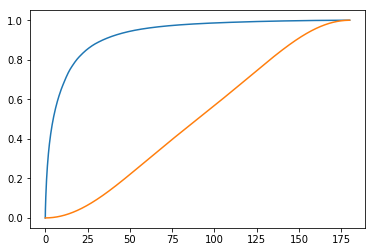

In [304]:
## Probability Distributions

angle_list = np.append(np.arange(.00001,.1,.001),np.arange(.1,180.05,.05))

p_scatt_prob = 2*pi*particle_scatt(angle_list)*sin(np.deg2rad(angle_list)) * pi/180
particle_cdf = cumtrapz(p_scatt_prob,angle_list, initial=0)
particle_cdf = particle_cdf/particle_cdf[-1] # renormalize

m_scatt_prob = 2*pi*molecular_scatt(angle_list)*sin(np.deg2rad(angle_list)) * pi/180
molecular_cdf = cumtrapz(m_scatt_prob,angle_list, initial=0)
molecular_cdf = molecular_cdf/molecular_cdf[-1] # renormalize

plt.plot(angle_list,particle_cdf)
plt.plot(angle_list,molecular_cdf)


In [14]:
## Source-Detector distances
# For POCAM2; +/- 2m
sDOM1 = np.sqrt( (107.66 - 69.79)**2 + 37**2)
sDOM2 = np.sqrt( (107.66 - 49.40)**2 + 37**2)
sDOM3 = np.sqrt( (107.66 - 29.98)**2 + 37**2)
sDOM4 = np.sqrt( (107.66 - 29.96)**2 + 0)
sDOM5 = np.sqrt( (107.66 - 69.10)**2 + 0)

## group velocity of light 
c_v = .2149 # +/- .0015 m/ns, for violet light (400nm)
c_b = .2175 # +/- .0015 m/ns, for blue light (465nm)

# Input: light colour ('v'/'violet' or 'b'/'blue'), and sDOM (1-5)
# Output: group velocity of light +/- .0015 m/ns, and sDOM distance +/- 2m
def parameter_selector(colour='v', sDOM=1):
    if colour[0] == 'v':
        c = .2149 # +/- .0015 m/ns, for violet light (405nm)
    elif colour[0] == 'u':
        c = .2153 # +/- .0015 m/ns, for uv light (~365nm)
    else:
        c = .2175 # +/- .0015 m/ns, for blue light (465nm)
    
    if sDOM == 1:
        sDOM_dist = np.sqrt( (107.66 - 69.79)**2 + 37**2)
    elif sDOM == 2:
        sDOM_dist = np.sqrt( (107.66 - 49.40)**2 + 37**2)
    elif sDOM == 3:
        sDOM_dist = np.sqrt( (107.66 - 29.98)**2 + 37**2)
    elif sDOM == 4:
        sDOM_dist = np.sqrt( (107.66 - 29.96)**2 + 0)
    else:
        sDOM_dist = np.sqrt( (107.66 - 69.10)**2 + 0)
        
    return (c, sDOM_dist)
        

In [16]:
## Helper functions (to deal with vectors)

# Input: [x,y,z] vector
# Output: distance from origin
def magnitude(v):
    return np.sqrt( v[0]*v[0] + v[1]*v[1] + v[2]*v[2] )

# Input: quaternions where q[0] is the scalar and q[1:] is the vector
# Output: q1*q2
def quaternion_multiply(q1,q2):
    q_scalar = q1[0]*q2[0] - np.dot(q1,q2)
    q_vector = q1[0]*q2[1:] + q2[0]*q1[1:] + np.cross(q1[1:],q2[1:])
    q = np.append(q_scalar, q_vector)
    return q

# rotation using quaternions
# Input: [x,y,z] vector v, rotation polar angle theta, azimuthal angle phi, wrt direction of v
# Output: rotated vector
def rotate(v,theta,phi):
    # First rotate by theta (note this won't work if v points along x axis)
    u1 = np.cross(v,[1,0,0])/magnitude(np.cross(v,[1,0,0])) # unit vector axis for 1st rotation
    q1 = np.append(cos(theta/2), u1*sin(theta/2)) # quaternion defining rotation by theta about u1
    q1_t = np.append(q1[0],-q1[1:]) # transpose of q1

    # rotation applied by q*(0,v)*q_t
    temp = quaternion_multiply(np.append(0,v),q1_t)
    v_rotated1 = quaternion_multiply(q1,temp)
    
    # repeat for rotation by phi
    u2 = v/magnitude(v) 
    q2 = np.append(cos(phi/2), u2*sin(phi/2))
    q2_t = np.append(q2[0],-q2[1:])
    
    temp = quaternion_multiply(v_rotated1,q2_t)
    v_rotated2 = quaternion_multiply(q2,temp)
    
    return v_rotated2[1:]




In [331]:
## Photon propagation - POCAM2

# Input: eta fraction of molecular scattering, 
#         sDOM distance, and colour of light ('v'/'violet' or 'b'/'blue')
# Output: photon arrival time (or nan if it gets absorbed)

def photon_propagation(eta,sDOM_dist,c,abs_len,scatt_len):
    
    #(m_scatt_ang_array, m_scatt_ang_prob, p_scatt_ang_array, p_scatt_ang_prob) = prob_dist
    
    # Initial conditions (origin, moving in +z direction)
    curr_pos = np.array([0, 0, 0]) # [x,y,z] in m
    direction = np.array([0,0,1]) # unit vector
    destination = np.array([0,0,sDOM_dist]) # intersection of sphere of radius sDOM-distance and line (curr_pos + direction)
    distance = 0 # total distance travelled
    flag = 0 # 0: particle still in motion; 1: particle reached detector; 2: particle absorbed

    while True:
        # Distance to scattering/absorption (sampled from exponential distribution)
        dist2scatt = np.random.exponential(scatt_len) # m
        dist2abs = np.random.exponential(abs_len) # m

        # distance to detector
        dist2det = magnitude(destination - curr_pos)

        # if absorption is smallest distance, absorb photon and break
        if dist2abs < dist2scatt and dist2abs < dist2det:
            curr_pos = curr_pos + direction*dist2abs
            distance += dist2abs
            flag = 2
            break

        # if scattering is smallest distance, scatter photon and continue
        elif dist2scatt < dist2det and dist2scatt < dist2abs:
            curr_pos = curr_pos + direction*dist2scatt
            distance += dist2scatt
            scatt_type = random()
            if scatt_type < eta:
                # molecular scattering
                #scatt_ang = np.random.choice(m_scatt_ang_array,p=m_scatt_ang_prob)
                scatt_ang = np.interp(random(),molecular_cdf,angle_list)
            else:
                # particulate scattering
                #scatt_ang = np.random.choice(p_scatt_ang_array,p=p_scatt_ang_prob)
                scatt_ang = np.interp(random(),particle_cdf,angle_list)
            # angles wrt direction: theta=scatt_ang and phi=2*pi*random()
            scatt_ang = np.radians(scatt_ang)
            phi = 2*pi*random()
            new_direction = rotate(direction,scatt_ang,phi)
            direction = new_direction/magnitude(new_direction) # unit vector (should already be, but just to be safe)
            # line: X = curr_pos + d*direction ; intersection with sphere, at distance d
            #d = -np.dot(direction,curr_pos) + np.sqrt(np.dot(direction,curr_pos)**2 - (magnitude(curr_pos)**2 - sDOM_dist**2))
            temp = np.dot(direction,curr_pos)
            d = -temp + np.sqrt(np.power(temp,2) - (np.power(magnitude(curr_pos),2) - np.power(sDOM_dist,2)))
            destination = curr_pos + d*direction

        # else detector is smallest distance, break and record distance
        else:
            distance += dist2det
            flag = 1
            break      
    
    if flag == 1:
        # photon reached detector
        travel_time = distance/c # in ns
        direct_time = sDOM_dist/c
        residual = travel_time - direct_time
        return residual
    else:
        # photon absorbed
        return np.nan
        



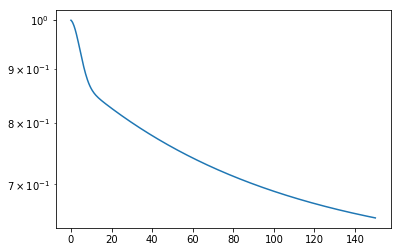

In [18]:
## Pulse-shape
# Gaussian centered at 0, width defined by full width half maximum (FWHM)
def gaussian(x,fwhm):
    a = 1/(4*np.sqrt(pi*np.log(2)))
    y = a * np.exp(-4*np.log(2)*x*x/(fwhm*fwhm))
    return y


## Curve fitting - arrival times follow a gaussian-double-exponential distribution
# Input: x values, gaussian full width half maximum, relative weight of exponential, 2 exponential time constants
# Output: gaussian+double_exponential function. Gaussian centered at x=0, with amplitude normalized to 1
def gaussian_double_exponential(x,fwhm,a,k1,k2):
    gaus = gaussian(x,fwhm)
    exp = a * np.exp( k1 * np.exp(k2*x) )
    y = (gaus+exp)/np.max(gaus+exp)
    return y

x = np.linspace(0,150,500)
y = gaussian_double_exponential(x,10,.9,.4,-.01)

fig, ax = plt.subplots()
ax.semilogy(x,y)


In [514]:
## Loop over photon propagation and plot histogram of arrival times

# Input: 
#   number of photons to simulate,
#   absorption and scattering lengths in m, 
#   eta the fraction of molecular scattering (float: 0-1), 
#   colour of light (string: 'v'/'violet', 'b'/'blue', 'u'/'uv'),
#   sDOM number (integer: 1-5), 
#   verbosity flag; when False suppress figures,
#   bin width in ns,
#   skip files already in path when True,
#   save results when True.
# Output: photon arrival times (0-150ns, 1ns uniform spacing) and save data as csv
def simulation(num_photons, abs_len, scatt_len, eta, colour, sDOM, save_path, verbose=False, bin_size=1, skip_repeat=True, save_results=True):

    # setup
    arrival_times = np.array([])
    file = 'abs{:.1f}_scatt{:.1f}_eta{:.3f}_{}_sDOM{:d}_P2_20V_photons{:d}.csv'.format(abs_len,scatt_len,eta,colour,sDOM,num_photons)
    file_path = save_path+file
    
    # skip repeat and return existing simulation data
    if (skip_repeat) and (file in os.listdir(save_path)):
        sim_data = np.genfromtxt(file_path, delimiter=',')
        print('skipping repeat: '+file)
        return sim_data 

    # group velocity of light +/- .0015 m/ns, and sDOM distance +/- 2m
    (c,sDOM_dist) = parameter_selector(colour,sDOM) 

    # propagate the photons
    start = time() # start timer
    for i in range(num_photons):
        residual = photon_propagation(eta,sDOM_dist,c,abs_len,scatt_len)
        arrival_times = np.append(arrival_times, residual)

    # remove nans
    condition = np.invert(np.isnan(arrival_times))
    arr_time_clean = np.extract(condition,arrival_times)

    # normalize by proportion of solid angle covered by detector
    #d = 3*0.0254 # PMT diameter
    #area = pi*d*d/4.0 # of detector
    #total_area = 4*pi*sDOM_dist*sDOM_dist # surface at source-detector radial distance
    #normalization = area/total_area
    #arr_time_clean = arr_time_clean * normalization

    # execution time
    end = time()
    elapsed = end-start
    print('execution time: ' + str(elapsed) + 's')

    # Plot hist of results
    fig, ax = plt.subplots()
    (n,bins,patches) = ax.hist(arr_time_clean,bins=150,range=(0,150),log=True)
    ax.set_title(tag+ '-raw_hist')
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('bincount')
    if not verbose:
        plt.close(fig)

    # gaussian pulse shape
    limit = bins[-1]
    x = np.linspace(-limit/2,limit/2,len(n)) # needs the same range and len as the histogram
    if colour[0] == 'b':
        fwhm = 8 # ns for blue
    else:
        fwhm = 10 # ns for violet and uv
    pulse_shape = gaussian(x,fwhm)

    # convolve detector response with pulse shape
    convolved = np.convolve(pulse_shape,n, mode='same')

    # save data as csv
    if save_results != False:
        with open(file_path, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(convolved)
        csvfile.close()
    
    return convolved




In [575]:
## Loop over parameters and generate popt_array

path = 'Data/Simulation_v2/uv/'

# Parameter selection
num_photons = 100000
colour = 'uv'
sDOM = 5 #1
bin_size = 1 # (ns)

# loop over paramters
scatt_len_list = np.arange(10,26,5)
abs_len_list = np.arange(25,41,5)
eta_list = np.arange(.10,0.36,.05)

#fig, ax = plt.subplots()

# store data
popt_array = np.zeros((len(abs_len_list),len(eta_list),len(scatt_len_list),4))

for i, scatt_len in enumerate(scatt_len_list):
    for j, eta in enumerate(eta_list):
        for k, abs_len in enumerate(abs_len_list):
            arr_time = simulation(num_photons, abs_len, scatt_len, eta, colour, sDOM, path, verbose=False, skip_repeat=True)
            #ax.semilogy(arr_time, label=str(abs_len))
            arr_time = arr_time / np.max(arr_time) # normalize

            ind = np.argmax(arr_time) # shift peak to 0
            sim_data_slice = arr_time[ind:-10] # remove edge effects from convolution
            x = np.arange(0,len(sim_data_slice)) * bin_size
            p0 = [10, .02, 3, -.01] # initial parameter guess
            popt, pcov = curve_fit(gaussian_double_exponential,x,sim_data_slice,p0)
            popt_array[k,j,i,:] = popt[:]

np.save(path+'popt_array_sDOM%i_(abs[25,40],eta[.10,.35],scatt[10,25],popt)'%(sDOM),popt_array)        




skipping repeat: abs25.0_scatt10.0_eta0.100_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs30.0_scatt10.0_eta0.100_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs35.0_scatt10.0_eta0.100_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs40.0_scatt10.0_eta0.100_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs25.0_scatt10.0_eta0.150_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs30.0_scatt10.0_eta0.150_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs35.0_scatt10.0_eta0.150_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs40.0_scatt10.0_eta0.150_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs25.0_scatt10.0_eta0.200_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs30.0_scatt10.0_eta0.200_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs35.0_scatt10.0_eta0.200_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs40.0_scatt10.0_eta0.200_uv_sDOM5_P2_20V_photons100000.csv
skipping repeat: abs25.0_scatt10.0_eta0.250_uv_sDOM5_P2_20V_phot

25 0.5325039673704991
30 0.5046836798643104
35 0.5452415584885095
40 0.5690658061457708


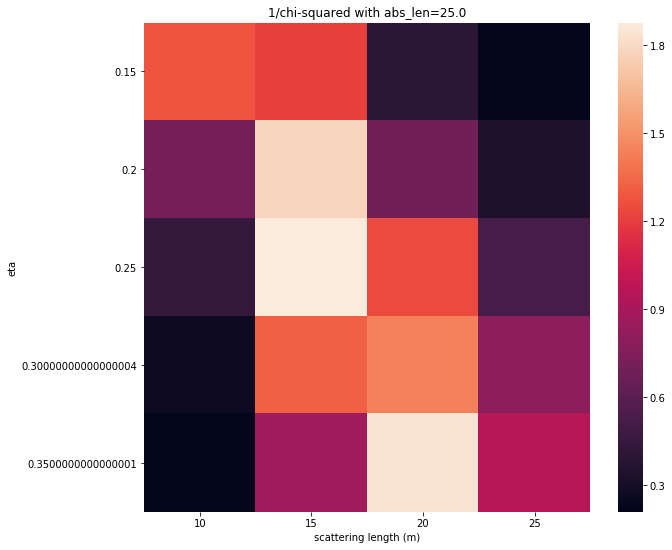

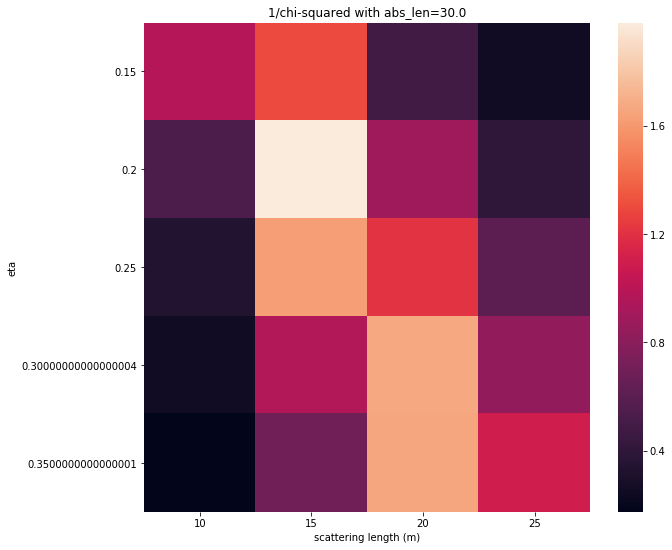

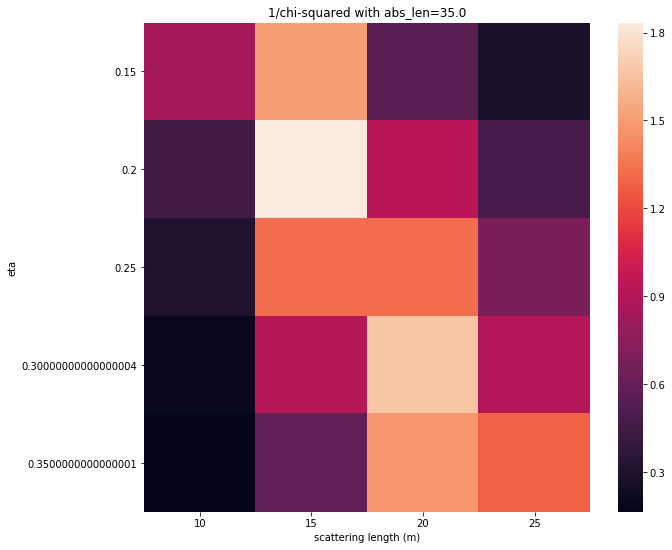

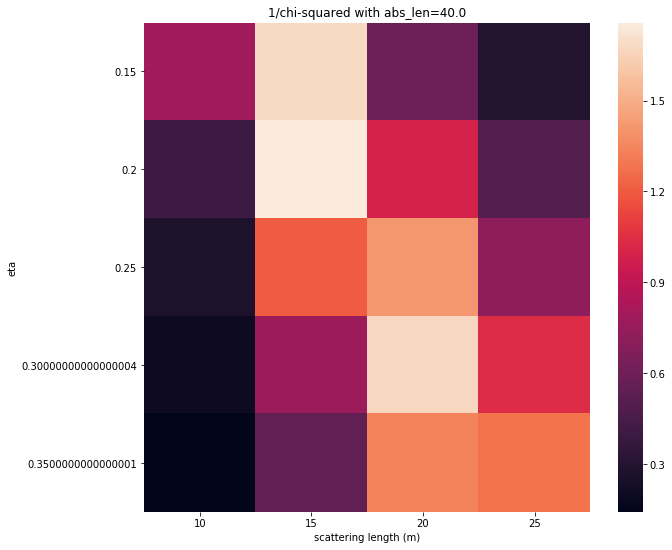

In [563]:
## Visualize parameter space
## plot 1/chi-squared as function of scatt_len and eta, for each abs_len value

colour = 'uv'
sDOM = 5

save_path = 'Data/Simulation_v2/%s/'%colour
file_sim = 'popt_array_sDOM%i_(abs[25,40],eta[.10,.35],scatt[10,25],popt).npy'%sDOM
popt_array = np.load(save_path+file_sim) #sDOM1

scatt_len_list = np.arange(10,26,5)
abs_len_list = np.arange(25,41,5)
eta_list = np.arange(.10,0.36,.05)

# Get measurement data
path_meas = 'Data/HERA1/%s/Measured_arrival_times/'%colour
file = "['P2'],['SDOM%i'],up,%s,['20V'],['2500Hz'].csv"%(sDOM,colour)
my_data = np.genfromtxt(path_meas+file, delimiter=',')
times = my_data[0][:]
counts = my_data[1][:]
noise = np.mean(counts[times<-15]) # time -100 to -15 ns
keep = (times>=0) & (times<=150)
times = times[keep]
counts = counts[keep]
counts_bkg_removed = np.array([max(0,hits-noise) for hits in counts])
counts = counts_bkg_removed / np.max(counts_bkg_removed) # normalize

a_array = popt_array[:,:,:,1]
k1_array = popt_array[:,:,:,2]
k2_array = popt_array[:,:,:,3]

for index, abs_len in enumerate(abs_len_list):

    chi_sqr_array_fit = np.zeros((len(eta_list),len(scatt_len_list)))

    # loop over simulations to optimize parameters
    for i in range(len(scatt_len_list)):
        scatt_len = scatt_len_list[i]
        for j in range(len(eta_list)):
            eta = eta_list[j]

            a = a_array[index,j,i]
            k1 = k1_array[index,j,i]
            k2 = k2_array[index,j,i]
            my_curve_fit = gaussian_double_exponential(times,10,a,k1,k2)

            # chi squared between sim and meas
            chisqr,p = chisquare(counts,my_curve_fit,ddof=3)
            #chisqr = binned_likelihood(counts,my_curve_fit)
            chi_sqr_array_fit[j,i] = chisqr
    
    print(abs_len, np.min(chi_sqr_array_fit))
    chi_sqr_inverse = 1/chi_sqr_array_fit
    
    fig, ax = plt.subplots(figsize=(10,9))
    sns.heatmap(chi_sqr_inverse,ax=ax,yticklabels=eta_list, xticklabels=scatt_len_list)
    ax.set_xlabel('scattering length (m)')
    ax.set_ylabel('eta')
    ax.set_title('1/chi-squared with abs_len=%2.1f'%abs_len)
    #plt.savefig('Data/POSEIDON1/Optimization/chi_squared_fine_abs%2.1f.png'%abs_len,bbox_inches='tight')



In [583]:
## Simulate over every baseline at a single parameter set, sum chi-squared over all parameters
## WARNING: make sure the relevant (corrected) measurement files are there before running

# Input: simulation parameters abs_len, scatt_len, eta
# Output: goodness of fit (chi-sqr or likelihood) to minimize

# interpolates between simulations instead of running them every time
# pros: faster ; cons: parameter space limited to that of pre-run simulations
def simultaneuous_fit_interpolated(abs_len, scatt_len, eta):
    # Parameters
    colour = 'blue'
    save_path = 'Data/Simulation_v2/%s/'%colour
    sDOM_list = [1,2] # [5,1,2,3]
    scatt_len_list = np.arange(20,46,5) # must match parameters used in popt_array
    abs_len_list = np.arange(50,71,5)
    eta_list = np.arange(.05,0.26,.05)
    #print(abs_len, scatt_len, eta) # for testing
    
    chi_sqr_total = 0
    
    for sDOM in sDOM_list:
        # measurement
        path_meas = 'Data/MINOS1/%s/Measured_arrival_times/'%colour
        file = "['P2'],['SDOM%i'],up,%s,['12V'],['2500Hz'],corrected.csv"%(sDOM,colour) 
        my_data = np.genfromtxt(path_meas+file, delimiter=',')
        times = my_data[0][100:(100+139)]
        counts_slice = my_data[1][100:(100+139)]
        
        # simulation
        file_sim = 'popt_array_sDOM%i_(abs[50,70],eta[.05,.25],scatt[20,45],popt).npy'%sDOM
        popt_array = np.load(save_path+file_sim) #sDOM1
        a_array = popt_array[:,:,:,1]
        k1_array = popt_array[:,:,:,2]
        k2_array = popt_array[:,:,:,3]

        # interpolator
        f_a = RegularGridInterpolator((abs_len_list,eta_list,scatt_len_list),a_array)
        f_k1 = RegularGridInterpolator((abs_len_list,eta_list,scatt_len_list),k1_array)
        f_k2 = RegularGridInterpolator((abs_len_list,eta_list,scatt_len_list),k2_array)
        
        # interpolate
        a = f_a([abs_len,eta,scatt_len])[0]
        k1 = f_k1([abs_len,eta,scatt_len])[0]
        k2 = f_k2([abs_len,eta,scatt_len])[0]
        
        # curve fit
        my_curve_fit = gaussian_double_exponential(times,10,a,k1,k2)
        sim_data = my_curve_fit/np.sum(my_curve_fit)*np.sum(counts_slice) # normalize to integrated count of meas
        
        # chi squared 
        #chisqr,p = chisquare(counts_slice,sim_data,ddof=3)
        chisqr = likelihood_ratio(counts_slice, sim_data)
        chi_sqr_total += chisqr
    
    #print(chi_sqr_total)
    return chi_sqr_total

# runs simulation at each function call
# Input eff_scatt_len instead of scatt_len because there should be less correlation with eta
def simultaneuous_fit_2(abs_len, eff_scatt_len, eta):
    # Parameters
    num_photons = 100000
    colour = 'violet'
    save_path = 'Data/Simulated_arrival_times/violet/'
    sDOM_list = [1,2] # [5,1,2,3]
    avg_cos = (1-eta)*.924
    scatt_len = eff_scatt_len*(1-avg_cos)
    print(abs_len, eff_scatt_len, eta) # for testing
    
    chi_sqr_total = 0
    
    for sDOM in sDOM_list:
        # measurement
        path_meas = 'Data/POSEIDON1/%s/Measured_arrival_times/'%colour
        file = "['P2'],['SDOM%i'],up,%s,['20V'],['2500Hz'],corrected.csv"%(sDOM,colour) 
        my_data = np.genfromtxt(path_meas+file, delimiter=',')
        counts_corrected = my_data[1][:]
        counts_slice = counts_corrected[100:(100+139)] # same length as sim_data_slice
        
        # simulation
        arr_time = simulation(num_photons, abs_len, scatt_len, eta, colour, sDOM, save_path, save_results=False)
        sim_data_slice = arr_time[1:-10] # remove edge effects
        sim_data = sim_data_slice/np.sum(sim_data_slice)*np.sum(counts_slice) # normalize to integrated count of meas
        
        # chi squared 
        #chisqr,p = chisquare(counts_slice,sim_data,ddof=3)
        #chisqr = binned_likelihood(counts_slice, sim_data)
        chisqr = likelihood_ratio(counts_slice, sim_data)
        chi_sqr_total += chisqr
    
    print(chi_sqr_total)
    return chi_sqr_total

# same as simultaneuous_fit_2 but vectorized input (for compatability with scipy.optimize.minimize)
def simultaneuous_fit_2_vector(x):
    abs_len = x[0]
    eff_scatt_len = x[1] 
    eta = x[2]
    # Parameters
    num_photons = 100000
    colour = 'violet'
    save_path = 'Data/Simulated_arrival_times/violet/'
    sDOM_list = [1,2] # [5,1,2,3]
    avg_cos = (1-eta)*.924
    scatt_len = eff_scatt_len*(1-avg_cos)
    print(abs_len, eff_scatt_len, eta) # for testing
    
    chi_sqr_total = 0
    
    for sDOM in sDOM_list:
        # measurement
        path_meas = 'Data/SANTACLAUS/%s/Measured_arrival_times/'%colour
        file = "['P2'],['SDOM%i'],up,%s,['20V'],['5000Hz'],corrected.csv"%(sDOM,colour) 
        my_data = np.genfromtxt(path_meas+file, delimiter=',')
        counts_corrected = my_data[1][:]
        counts_slice = counts_corrected[100:(100+139)] # same length as sim_data_slice
        
        # simulation
        arr_time = simulation(num_photons, abs_len, scatt_len, eta, colour, sDOM, save_path, save_results=False, skip_repeat=False)
        sim_data_slice = arr_time[1:-10] # remove edge effects
        sim_data = sim_data_slice/np.sum(sim_data_slice)*np.sum(counts_slice) # normalize to integrated count of meas
        
        # chi squared 
        #chisqr,p = chisquare(counts_slice,sim_data,ddof=3)
        chisqr = likelihood_ratio(counts_slice, sim_data)
        chi_sqr_total += chisqr
    
    print(chi_sqr_total)
    return chi_sqr_total
    

In [587]:
## Minimize total chi squared

m = Minuit(simultaneuous_fit_interpolated, abs_len=54, scatt_len=35, eta=.15,
           error_abs_len=3, error_scatt_len=2, error_eta=.02,
           limit_abs_len=(50, 70), limit_scatt_len=(20, 45), limit_eta=(0.05, .25),
           errordef=.5)


print('Run optimiser')
m.migrad()  # run optimiser
pprint(m.get_param_states())
print('fmin')
pprint(m.get_fmin())

print('Hesse errors')
m.hesse()   # run covariance estimator
print(m.errors)  


Run optimiser
[Param(number=0, name='abs_len', value=54.99926552485427, error=0.04652152726183445, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=50.0, upper_limit=70.0),
 Param(number=1, name='scatt_len', value=32.33036200963829, error=0.5064399944793703, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=20.0, upper_limit=45.0),
 Param(number=2, name='eta', value=0.123883805942328, error=0.005046639164424313, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=0.05, upper_limit=0.25)]
fmin
FMin(fval=790.3547442660056, edm=3.935450837814609e-05, tolerance=0.1, nfcn=202, ncalls=202, up=0.5, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False)
Hesse errors
<ErrorView

In [138]:
## binned Poissonian likelihood
# more accurate for fits with a small number of entries per bin

def binned_likelihood(f_obs, f_exp):
    cost = 2*np.sum(f_exp - f_obs*np.log(f_exp)) # I don't think this is correct
    return cost

def likelihood_ratio(f_obs, f_exp):
    cost = 2*np.sum(f_exp - f_obs + f_obs*np.log(f_obs/f_exp))
    return cost

# Poisson likelihood:
# mc - data*log(mc)

execution time: 134.9268033504486s
chi-squared_poisson =  1087.4045864698714


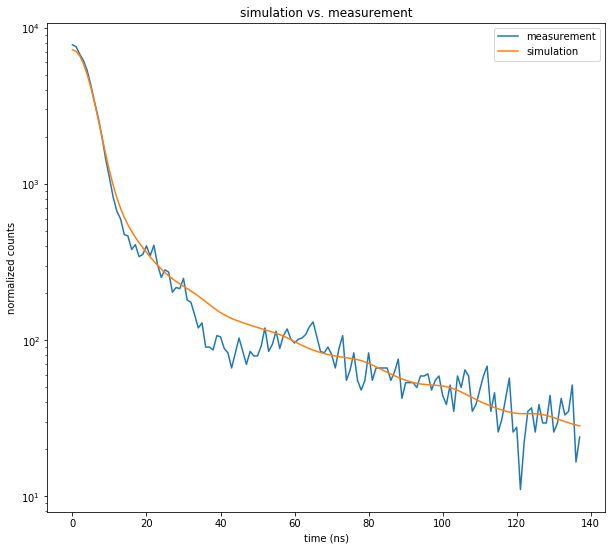

In [511]:
## comparing solution to measurement

sDOM = 1
colour = 'blue'

# measurement
path_meas = 'Data/HERA1/%s/Measured_arrival_times/'%colour
file = "['P2'],['SDOM%i'],up,%s,['12V'],['2500Hz'],corrected.csv"%(sDOM,colour)
my_data = np.genfromtxt(path_meas+file, delimiter=',')
times = my_data[0][:]
counts = my_data[1][:]
counts = counts[100:(100+138)]
times = times[100:(100+138)]

# simulation
path_sim = 'Data/Simulation_v2/%s/'%colour
sim_data = simulation(100000, 65, 30.9, .106, colour, sDOM, path_sim, verbose=False, skip_repeat=False)
index = np.argmax(sim_data)
sim_data_slice = sim_data[index:index+len(counts)]
sim_data = sim_data_slice / np.sum(sim_data_slice) * np.sum(counts) # normalize

chisq_poisson = likelihood_ratio(counts, sim_data)
print('chi-squared_poisson = ', chisq_poisson)

# plot
fig, ax = plt.subplots(figsize=(10,9))
ax.semilogy(times,counts,label='measurement')
ax.semilogy(sim_data,label='simulation')
#ax.semilogy(sim_data2,label='original_simulation')
#ax.semilogy(times,my_curve,label='fit')
ax.set_xlabel('time (ns)')
ax.set_ylabel('normalized counts')
ax.set_title('simulation vs. measurement')
ax.legend()
#plt.savefig('Data/POSEIDON1/violet/Optimization/optimized_sim_vs_meas.png',bbox_inches='tight')



In [268]:
## simultaneuous_fit_2
## POSEIDON, fix eta at .15
m = Minuit(simultaneuous_fit_2, abs_len=30, eff_scatt_len=50, eta=.15, fix_eta=True,
           error_abs_len=2, error_eff_scatt_len=5, error_eta=.05,
           limit_abs_len=(0, None), limit_eff_scatt_len=(0, None), limit_eta=(0, 1),
           errordef=.5)

print('Run optimiser')
m.migrad()  # run optimiser
#print(m.values)
pprint(m.get_param_states())
print('fmin')
pprint(m.get_fmin())

print('Hesse errors')
m.hesse()   # run covariance estimator
print(m.errors)  

Run optimiser
30.000000000000004 50.0 0.15
execution time: 223.66700196266174s
execution time: 225.1125898361206s
13767.182593207835
30.16204943033232 50.0 0.15
execution time: 225.4494571685791s
execution time: 219.90407800674438s
13480.317101461405
29.83795145208008 50.0 0.15
execution time: 222.89887595176697s
execution time: 245.95251417160034s
13707.379567930479
30.016204903552886 50.0 0.15
execution time: 255.33086109161377s
execution time: 254.45821619033813s
13663.286196361129
29.983795105271003 50.0 0.15
execution time: 224.26752591133118s
execution time: 251.18358516693115s
14069.852917386957
30.00162048995844 50.0 0.15
execution time: 255.08109998703003s
execution time: 241.5802538394928s
13675.729508646906
29.998379510129798 50.0 0.15
execution time: 238.79815006256104s
execution time: 216.95805311203003s
13341.081324278655
30.000000000000004 50.40512267627867 0.15
execution time: 211.17853903770447s
execution time: 212.70784091949463s
13919.135105167607
30.000000000000004 

RuntimeError: exception was raised in user function
User function arguments:
          abs_len = +29.999804
    eff_scatt_len = +50.000000
              eta = +0.150000


In [279]:
## Alternate minimizer algorithm
result = minimize(simultaneuous_fit_2_vector, [35,49,.15], method='Nelder-Mead', 
                  options={'maxiter':100, 'fatol':50}) # , bounds=[(0,None),(0,None),(0,1)]

30.0 49.0 0.25
execution time: 1953.1838598251343s
execution time: 181.83391404151917s
9572.394030200992
31.5 49.0 0.25
execution time: 178.75835490226746s
execution time: 181.24536085128784s
9761.326603327216
30.0 51.45 0.25
execution time: 310.9903223514557s
execution time: 166.46439909934998s
10794.74755348204
31.5 46.55 0.25
execution time: 186.57851099967957s
execution time: 184.33959007263184s
8306.28756907847
32.25 44.099999999999994 0.25
execution time: 194.20724391937256s
execution time: 192.90942215919495s
7231.524668048027
30.75 44.099999999999994 0.25
execution time: 191.72743701934814s
execution time: 189.78350496292114s
7241.864149629455
33.0 39.19999999999999 0.25
execution time: 219.46276569366455s
execution time: 217.07674407958984s
5144.323105207617
34.5 34.29999999999998 0.25
execution time: 250.05032801628113s
execution time: 249.5002520084381s
3754.420590781569
36.0 34.29999999999998 0.25
execution time: 298.44013810157776s
execution time: 299.24786615371704s
3427.

execution time: 298.36076402664185s
2859.6860607841095
38.331754015758634 27.978255353867993 0.25
execution time: 299.8092451095581s
execution time: 298.8708209991455s
2838.560417608467
38.33108030073345 27.97756155878303 0.25
execution time: 298.17368602752686s
execution time: 298.89231419563293s
2775.8503464762034
38.33208536915481 27.975995518267126 0.25
execution time: 302.15415120124817s
execution time: 299.3424029350281s
3084.3424843833836
38.33120731031522 27.97801748700438 0.25
execution time: 300.99924993515015s
execution time: 298.10805892944336s
2841.8995989420837
38.331499996595085 27.977343497425295 0.25
execution time: 300.9795792102814s
execution time: 298.43709897994995s
2983.2384752226726
38.33141715824604 27.977908456325512 0.25
execution time: 298.4773349761963s
execution time: 299.25173687934875s
3070.6682656693783
38.33200253080577 27.976560477167343 0.25
execution time: 299.167946100235s
execution time: 299.09206795692444s
2908.544069526498
38.332422226667404 27.9

KeyboardInterrupt: 

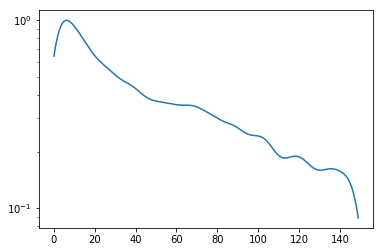

In [546]:
plt.semilogy(arr_time)

#ind = np.argmax(arr_time)# 
#sim_data_slice = arr_time[ind:-10] # remove edge effects from convolution
#x = np.arange(0,len(sim_data_slice)) * bin_size
#p0 = [10, .02, 3, -.01] # initial parameter guess
#popt, pcov = curve_fit(gaussian_double_exponential,x,sim_data_slice,p0)
#print(popt)